In [97]:
# Libraries 

import vectorbt as vbt
import pandas as pd 
import numpy as np 
import yfinance as yf
from sklearn.mixture import GaussianMixture
import quantstats as qs
qs.extend_pandas()

In [98]:
# Load your data
start_date = '2014-09-16'
end_date = '2024-11-08'

data = vbt.YFData.download('BTC-USD', start=start_date, end=end_date).get('Close')

print(data)

Date
2014-09-17 00:00:00+00:00      457.334015
2014-09-18 00:00:00+00:00      424.440002
2014-09-19 00:00:00+00:00      394.795990
2014-09-20 00:00:00+00:00      408.903992
2014-09-21 00:00:00+00:00      398.821014
                                 ...     
2024-11-03 00:00:00+00:00    68741.117188
2024-11-04 00:00:00+00:00    67811.507812
2024-11-05 00:00:00+00:00    69359.562500
2024-11-06 00:00:00+00:00    75639.078125
2024-11-07 00:00:00+00:00    75904.859375
Freq: D, Name: Close, Length: 3705, dtype: float64


In [99]:
# Fit the Machine Learning model 

# GMM
gmm = GaussianMixture(n_components=2)
gmm.fit(data.values.reshape(-1, 1))
regimes = gmm.predict(data.values.reshape(-1, 1))

In [100]:
# Generate signals
entries = (regimes == 0)  # Example condition for entry
exits = (regimes == 1)    # Example condition for exit

# Set initial capital
initial_capital = 1000000

In [101]:
# Backtest
portfolio = vbt.Portfolio.from_signals(
                                    data, 
                                    entries,
                                    exits,
                                    fees = 0.001,
                                    init_cash=initial_capital,
                                    freq='1D'
                                        )

In [102]:
portfolio.stats()

Start                         2014-09-17 00:00:00+00:00
End                           2024-11-07 00:00:00+00:00
Period                               3705 days 00:00:00
Start Value                                   1000000.0
End Value                                40768528.80273
Total Return [%]                             3976.85288
Benchmark Return [%]                       16497.247723
Max Gross Exposure [%]                            100.0
Total Fees Paid                            252907.45858
Max Drawdown [%]                              74.907268
Max Drawdown Duration                 521 days 00:00:00
Total Trades                                          4
Total Closed Trades                                   4
Total Open Trades                                     0
Open Trade PnL                                      0.0
Win Rate [%]                                      100.0
Best Trade [%]                              3021.733941
Worst Trade [%]                                1

In [103]:
portfolio.total_profit()

39768528.80272997

In [127]:
portfolio.plot().show()

In [131]:
# Extract the daily returns of the portfolio
portfolio_returns = portfolio.returns()

print(portfolio_returns)

Date
2014-09-17   -0.000999
2014-09-18   -0.071926
2014-09-19   -0.069843
2014-09-20    0.035735
2014-09-21   -0.024659
                ...   
2024-11-03    0.000000
2024-11-04    0.000000
2024-11-05    0.000000
2024-11-06    0.000000
2024-11-07    0.000000
Name: Close, Length: 3705, dtype: float64


In [105]:
# Benchmark 

start_date = '2014-09-18'
end_date = '2024-11-08'

# Download S&P 500 data (using SPY ETF as a proxy)
spy_data = vbt.YFData.download('SPY', start = start_date, end = end_date).get('Close')

# Benchmark
benchmark_portfolio = vbt.Portfolio.from_signals(
                                    spy_data,
                                    fees = 0.001,
                                    init_cash=initial_capital,
                                    freq='1D'
)


In [132]:
# Benchmark portforlio returns

benchmark_returns = benchmark_portfolio.returns()

print(benchmark_returns)

Date
2014-09-17 04:00:00   -0.000999
2014-09-18 04:00:00    0.005330
2014-09-19 04:00:00   -0.000901
2014-09-22 04:00:00   -0.007723
2014-09-23 04:00:00   -0.005724
                         ...   
2024-11-01 04:00:00    0.004221
2024-11-04 05:00:00   -0.002154
2024-11-05 05:00:00    0.012092
2024-11-06 05:00:00    0.024866
2024-11-07 05:00:00    0.007732
Name: Close, Length: 2554, dtype: float64


In [135]:
# Risk free rate 

rf = 0.005

In [136]:
# Remove timezone information from both indices
portfolio_returns.index = portfolio_returns.index.tz_localize(None)
benchmark_returns.index = benchmark_returns.index.tz_localize(None)

qs.reports.metrics(portfolio_returns, benchmark=benchmark_returns, rf=rf)

                    Benchmark    Strategy
------------------  -----------  ----------
Start Period        2014-09-17   2014-09-17
End Period          2024-11-07   2024-11-07
Risk-Free Rate      0.5%         0.5%
Time in Market      69.0%        60.0%

Cumulative Return   255.55%      3,980.93%
CAGR﹪              9.01%        28.7%

Sharpe              0.63         0.77
Prob. Sharpe Ratio  98.63%       99.62%
Sortino             0.88         1.13
Sortino/√2          0.62         0.8
Omega               1.22         1.22

Max Drawdown        -33.72%      -74.91%
Longest DD Days     708          521

Gain/Pain Ratio     0.17         0.22
Gain/Pain (1M)      0.98         1.45

Payoff Ratio        0.85         0.88
Profit Factor       1.17         1.22
Common Sense Ratio  1.18         1.39
CPC Index           0.54         0.59
Tail Ratio          1.01         1.14
Outlier Win Ratio   15.86        5.82
Outlier Loss Ratio  8.33         2.61

MTD                 4.74%        0.0%
3M           

## Portfolio of assets

In [156]:
import pandas as pd
import numpy as np
import yfinance as yf
import riskfolio as pf
from riskfolio import Portfolio
import vectorbt as vbt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [184]:
# Define the ticker symbols for the top 5 defence stocks
tickers = ['LMT', 'RTX', 'BA', 'NOC', 'GD']

# Fetch historical price data
def_stocks = yf.download(tickers, start="2020-01-01", end="2024-11-13")['Adj Close']
def_stocks.columns = tickers


[*********************100%***********************]  5 of 5 completed


In [185]:
print(def_stocks)

                                  LMT         RTX          BA         NOC  \
Date                                                                        
2020-01-02 00:00:00+00:00  331.348572  158.190170  351.584351  329.125702   
2020-01-03 00:00:00+00:00  330.791901  159.741653  364.234985  346.993073   
2020-01-06 00:00:00+00:00  331.766083  161.435028  363.680328  347.751709   
2020-01-07 00:00:00+00:00  335.285156  159.599838  364.904083  346.956024   
2020-01-08 00:00:00+00:00  329.410095  160.007614  361.849243  342.625610   
...                               ...         ...         ...         ...   
2024-11-06 00:00:00+00:00  147.160004  308.459991  551.820007  523.140015   
2024-11-07 00:00:00+00:00  150.979996  306.000000  551.840027  520.580017   
2024-11-08 00:00:00+00:00  151.679993  309.470001  564.559998  528.989990   
2024-11-11 00:00:00+00:00  148.960007  313.910004  570.580017  533.700012   
2024-11-12 00:00:00+00:00  145.169998  312.049988  565.960022  531.390015   

In [186]:
# Calculating returns

Y = def_stocks[tickers].pct_change().dropna()

display(Y.head())


LMT       RTX        BA       NOC        GD
Date                                                                       
2020-01-03 00:00:00+00:00 -0.001680  0.009808  0.035982  0.054287  0.001371
2020-01-06 00:00:00+00:00  0.002945  0.010601 -0.001523  0.002186  0.002152
2020-01-07 00:00:00+00:00  0.010607 -0.011368  0.003365 -0.002288 -0.003188
2020-01-08 00:00:00+00:00 -0.017523  0.002555 -0.008372 -0.012481  0.001502
2020-01-09 00:00:00+00:00  0.014998  0.006261  0.009488  0.005590  0.001499

In [187]:
# Building the portfolio object
port = pf.Portfolio(returns=Y)

# Calculating optimal portfolio

# Select method and estimate input parameters:

method_mu='hist' # Method to estimate expected returns based on historical data.
method_cov='hist' # Method to estimate covariance matrix based on historical data.

port.assets_stats(method_mu=method_mu, method_cov=method_cov)

# Estimate optimal portfolio:

model='Classic' # Could be Classic (historical), BL (Black Litterman) or FM (Factor Model)
rm = 'MV' # Risk measure used, this time will be variance
obj = 'Sharpe' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
hist = True # Use historical scenarios for risk measures that depend on scenarios
rf = 0 # Risk free rate
l = 0 # Risk aversion factor, only useful when obj is 'Utility'

w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

display(w.T)

LMT      RTX        BA       NOC            GD
weights  5.168901e-10  0.89559  0.043353  0.061057  3.014334e-09

In [188]:
# Calculate portfolio returns using optimized weights
weighted_portfolio_returns = (def_stocks.pct_change().dropna() * w.values.flatten()).sum(axis=1)

# Weighted portfolio prices

weighted_portfolio_prices = (1 + weighted_portfolio_returns).cumprod() * 100  # Starting index at 100

print(weighted_portfolio_prices)


Date
2020-01-03 00:00:00+00:00    101.365822
2020-01-06 00:00:00+00:00    102.335018
2020-01-07 00:00:00+00:00    101.293772
2020-01-08 00:00:00+00:00    101.411599
2020-01-09 00:00:00+00:00    102.056595
                                ...    
2024-11-06 00:00:00+00:00    192.731404
2024-11-07 00:00:00+00:00    191.297557
2024-11-08 00:00:00+00:00    193.620204
2024-11-11 00:00:00+00:00    196.302823
2024-11-12 00:00:00+00:00    195.140327
Length: 1224, dtype: float64


In [189]:
# Import necessary modules
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np

# Assume weighted_portfolio_returns is already calculated
portfolio_returns_df = pd.DataFrame({
    'returns': weighted_portfolio_returns,
    'price': (1 + weighted_portfolio_returns).cumprod() * 100  # Starting index at 100 for cumulative price
})

# Fit GMM on weighted portfolio returns to detect regimes
gmm = GaussianMixture(n_components=2, random_state=42)
gmm.fit(portfolio_returns_df['returns'].values.reshape(-1, 1))
regimes = gmm.predict(portfolio_returns_df['returns'].values.reshape(-1, 1))

# Define GMM-based entry and exit signals
portfolio_returns_df['gmm_entry'] = regimes == 0  # Enter when in regime 0
portfolio_returns_df['gmm_exit'] = regimes == 1   # Exit when in regime 1

# Feature engineering for Random Forest
portfolio_returns_df['rolling_mean'] = portfolio_returns_df['price'].rolling(window=5).mean()
portfolio_returns_df['volatility'] = portfolio_returns_df['price'].rolling(window=5).std()
portfolio_returns_df['momentum'] = portfolio_returns_df['price'].diff(5)
portfolio_returns_df = portfolio_returns_df.dropna()

# Train Random Forest model
X = portfolio_returns_df[['returns', 'rolling_mean', 'volatility', 'momentum']]
y = portfolio_returns_df['gmm_entry'].astype(int)

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X, y)
portfolio_returns_df['rf_signal'] = rf_model.predict(X)

# Combine GMM and RF signals for independent signal approach
portfolio_returns_df['combined_entry'] = (portfolio_returns_df['gmm_entry'] | (portfolio_returns_df['rf_signal'] == 1))
portfolio_returns_df['combined_exit'] = (portfolio_returns_df['gmm_exit'] | (portfolio_returns_df['rf_signal'] == 0))


In [195]:
# Define entries and exits based on combined signal for the portfolio
entries = portfolio_returns_df['combined_entry']
exits = portfolio_returns_df['combined_exit']

# Run backtest on the portfolio as a whole
portfolio_backtest = vbt.Portfolio.from_signals(
    portfolio_returns_df['price'],
    entries=entries,
    exits=exits,
    init_cash=100000, 
    fees=0.001, 
    freq='d'

)

In [196]:
# Display performance statistics
print(portfolio_backtest.stats())

Start                         2020-01-10 00:00:00+00:00
End                           2024-11-12 00:00:00+00:00
Period                               1219 days 00:00:00
Start Value                                    100000.0
End Value                                 116371.589212
Total Return [%]                              16.371589
Benchmark Return [%]                          93.166328
Max Gross Exposure [%]                            100.0
Total Fees Paid                            22057.430357
Max Drawdown [%]                              28.880956
Max Drawdown Duration                1001 days 00:00:00
Total Trades                                        125
Total Closed Trades                                 124
Total Open Trades                                     1
Open Trade PnL                              2177.549046
Win Rate [%]                                  48.387097
Best Trade [%]                                 9.311526
Worst Trade [%]                               -7

In [193]:
# Remove timezone information from both indices
weighted_portfolio_returns.index = weighted_portfolio_returns.index.tz_localize(None)
benchmark_returns.index = benchmark_returns.index.tz_localize(None)

qs.reports.metrics(weighted_portfolio_returns, benchmark=benchmark_returns, rf=0.05)

/opt/anaconda3/lib/python3.12/site-packages/quantstats/utils.py:279: FutureWarning:

The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.



                    Benchmark    Strategy
------------------  -----------  ----------
Start Period        2020-01-03   2020-01-03
End Period          2024-11-12   2024-11-12
Risk-Free Rate      5.0%         5.0%
Time in Market      100.0%       100.0%

Cumulative Return   98.59%       92.51%
CAGR﹪              10.23%       9.74%

Sharpe              0.54         0.47
Prob. Sharpe Ratio  48.26%       39.72%
Sortino             0.75         0.68
Sortino/√2          0.53         0.48
Omega               1.09         1.09

Max Drawdown        -33.72%      -42.4%
Longest DD Days     708          413

Gain/Pain Ratio     0.16         0.13
Gain/Pain (1M)      0.88         0.91

Payoff Ratio        0.95         0.94
Profit Factor       1.16         1.13
Common Sense Ratio  1.09         1.17
CPC Index           0.6          0.57
Tail Ratio          0.94         1.03
Outlier Win Ratio   4.28         3.52
Outlier Loss Ratio  4.26         3.71

MTD                 4.74%        6.7%
3M             

## Option Hedging model example 

In [197]:
# Parameters for the stock and option
S0 = 100      # initial stock price
K = 100       # strike price
T = 1         # time to maturity (in years)
r = 0.05      # risk-free rate
sigma = 0.2   # volatility of the underlying stock
mu = 0.1      # expected return of the stock

# Simulation parameters
N = 252       # number of time steps in a year
dt = T / N    # time increment
num_paths = 100  # number of simulated paths

In [198]:
def generate_gbm_paths(S0, mu, sigma, T, dt, num_paths):
    steps = int(T / dt)
    paths = np.zeros((steps + 1, num_paths))
    paths[0] = S0
    for t in range(1, steps + 1):
        z = np.random.standard_normal(num_paths)  # Random normal variables
        paths[t] = paths[t - 1] * np.exp((mu - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * z)
    return paths

stock_paths = generate_gbm_paths(S0, mu, sigma, T, dt, num_paths)

In [199]:
from scipy.stats import norm

def bs_delta(S, K, T, t, r, sigma, option_type='call'):
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * (T - t)) / (sigma * np.sqrt(T - t))
    if option_type == 'call':
        return norm.cdf(d1)
    elif option_type == 'put':
        return norm.cdf(d1) - 1  # for a put option


In [200]:
# Initialize portfolio values
hedge_portfolio_values = []
option_values = []

for path in range(num_paths):
    portfolio_value = 0
    cash_position = 0
    stock_position = 0
    path_stock = stock_paths[:, path]
    
    for t in range(N):
        S = path_stock[t]
        tau = T - t * dt
        
        # Calculate delta and option value at current time
        delta = bs_delta(S, K, T, t * dt, r, sigma)
        option_value = S * delta - K * np.exp(-r * tau) * norm.cdf(delta - 1)  # Black-Scholes option value
        option_values.append(option_value)
        
        # Update stock position to hedge
        new_stock_position = delta
        stock_to_buy_or_sell = new_stock_position - stock_position
        stock_position = new_stock_position
        
        # Update cash position (adjusted for cost of purchasing stocks for hedge)
        cash_position = cash_position * np.exp(r * dt) - stock_to_buy_or_sell * S
        portfolio_value = stock_position * S + cash_position  # Hedge portfolio value
        
        hedge_portfolio_values.append(portfolio_value)

# Convert to arrays for plotting
hedge_portfolio_values = np.array(hedge_portfolio_values).reshape((num_paths, N))
option_values = np.array(option_values).reshape((num_paths, N))


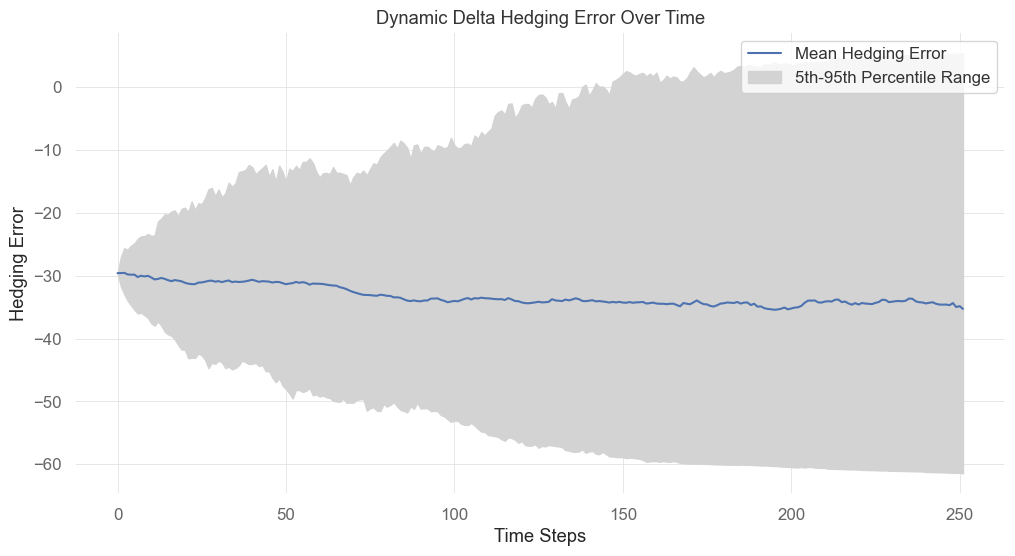

In [203]:
import matplotlib.pyplot as plt

# Calculate hedging errors
hedging_errors = hedge_portfolio_values - option_values

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(np.mean(hedging_errors, axis=0), label='Mean Hedging Error')
plt.fill_between(range(N), 
                 np.percentile(hedging_errors, 5, axis=0), 
                 np.percentile(hedging_errors, 95, axis=0), 
                 color='lightgrey', label='5th-95th Percentile Range')
plt.title('Dynamic Delta Hedging Error Over Time')
plt.xlabel('Time Steps')
plt.ylabel('Hedging Error')
plt.legend()
plt.show()


## Option model with real data 

In [229]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from alpaca.data import StockHistoricalDataClient
from alpaca.data.requests import StockBarsRequest
from alpaca.data.timeframe import TimeFrame
from scipy.stats import norm
import datetime
from keys.config_alpaca_keys import API_KEY, SECRET_KEY

# Set up Alpaca API (replace with your keys)
api_key = API_KEY
api_secret = SECRET_KEY
client = StockHistoricalDataClient(api_key, api_secret)


In [230]:
# Define the time range for fetching GOOG historical data

# Fetch daily bars for GOOG
request_params = StockBarsRequest(
    symbol_or_symbols=['GOOG'],
    timeframe=TimeFrame.Day,
    start=datetime.datetime(2024, 10, 13),
    end=datetime.datetime(2024, 11, 13)
)

In [231]:
# Retrieve the GOOG data
stock_data = client.get_stock_bars(request_params).df
#stock_data = stock_data[stock_data['symbol'] == "GOOG"]  # Filter for GOOG if multiple symbols
stock_data = stock_data[['close']]  # Use only close prices
stock_data = stock_data.reset_index(drop=True)

print(stock_data)

     close
0   166.35
1   166.90
2   166.74
3   164.51
4   165.05
5   165.80
6   166.82
7   164.48
8   164.53
9   166.99
10  168.34
11  171.14
12  176.14
13  172.69
14  172.65
15  170.68
16  171.41
17  178.33
18  182.28
19  179.86
20  181.97
21  183.32


In [232]:
from alpaca.data.live.option import *
from alpaca.data.historical.option import *
from alpaca.data.requests import *
from alpaca.data.timeframe import *
from alpaca.trading.client import *
from alpaca.trading.stream import *
from alpaca.trading.requests import *
from alpaca.trading.enums import *
from alpaca.common.exceptions import APIError

#### We use paper environment for this example ####
paper = True 

trade_api_url = None
trade_api_wss = None
data_api_url = None
option_stream_data_wss = None

# setup clients
trade_client = TradingClient(api_key=API_KEY, secret_key=SECRET_KEY, paper=paper, url_override=trade_api_url)

# setup option historical data client
option_historical_data_client = OptionHistoricalDataClient(api_key, api_secret, url_override = data_api_url)

In [233]:
# get list of assets which are options enabled
# - we can filter assets by `options_enabled` attribute
# - asset object has `options_enabled` attribute if it is options enabled
req = GetAssetsRequest(
  attributes = "options_enabled"  
)

In [234]:
# get list of options contracts for the given underlying symbol (e.g. SPY,AAPL)
# - get_option_contracts() is a new method to get list of options contracts
# - in this example, we get 2 options contracts for SPY,AAPL
# - you can continue to fetch options contracts by specifying page_token from next_page_token of response
underlying_symbols = ["GOOG"]
req = GetOptionContractsRequest(
    underlying_symbols = underlying_symbols,               # specify underlying symbols
    status = AssetStatus.ACTIVE,                           # specify asset status: active (default)
    expiration_date = None,                                # specify expiration date (specified date + 1 day range)
    expiration_date_gte = None,                            # we can pass date object
    expiration_date_lte = None,                            # or string (YYYY-MM-DD)
    root_symbol = None,                                    # specify root symbol
    type = None,                                           # specify option type (ContractType.CALL or ContractType.PUT)
    style = None,                                          # specify option style (ContractStyle.AMERICAN or ContractStyle.EUROPEAN)
    strike_price_gte = None,                               # specify strike price range
    strike_price_lte = None,                               # specify strike price range
    limit = 2,                                             # specify limit
    page_token = None,                                     # specify page token
)
res = trade_client.get_option_contracts(req)
res

{   'next_page_token': 'Mg==',
    'option_contracts': [   {   'close_price': '110.41',
                                'close_price_date': datetime.date(2024, 11, 8),
                                'expiration_date': datetime.date(2024, 11, 15),
                                'id': '282364e9-41bb-4b82-be3d-67df04f4333e',
                                'name': 'GOOG Nov 15 2024 70 Call',
                                'open_interest': '9',
                                'open_interest_date': datetime.date(2024, 11, 12),
                                'root_symbol': 'GOOG',
                                'size': '100',
                                'status': <AssetStatus.ACTIVE: 'active'>,
                                'strike_price': 70.0,
                                'style': <ExerciseStyle.AMERICAN: 'american'>,
                                'symbol': 'GOOG241115C00070000',
                                'tradable': True,
                                'type': <Cont

In [235]:
from datetime import datetime, timedelta
from zoneinfo import ZoneInfo

# get call options contracts
underlying_symbols = ["GOOG"]

# specify expiration date range
now = datetime.now(tz = ZoneInfo("America/New_York"))
day1 = now + timedelta(days = 1)
day60 = now + timedelta(days = 60)

req = GetOptionContractsRequest(
    underlying_symbols = underlying_symbols,                     # specify underlying symbols
    status = AssetStatus.ACTIVE,                                 # specify asset status: active (default)
    expiration_date = None,                                      # specify expiration date (specified date + 1 day range)
    expiration_date_gte = day1.date(),                           # we can pass date object
    expiration_date_lte = day60.strftime(format = "%Y-%m-%d"),   # or string
    root_symbol = None,                                          # specify root symbol
    type = "call",                                                # specify option type: call/put
    style = ExerciseStyle.AMERICAN,                              # specify option style: american
    strike_price_gte = None,                                     # specify strike price range
    strike_price_lte = None,                                     # specify strike price range
    limit = 100,                                                 # specify limit
    page_token = None,                                           # specify page
)
res = trade_client.get_option_contracts(req)
res.option_contracts[:2]

[{   'close_price': '110.41',
     'close_price_date': datetime.date(2024, 11, 8),
     'expiration_date': datetime.date(2024, 11, 15),
     'id': '282364e9-41bb-4b82-be3d-67df04f4333e',
     'name': 'GOOG Nov 15 2024 70 Call',
     'open_interest': '9',
     'open_interest_date': datetime.date(2024, 11, 12),
     'root_symbol': 'GOOG',
     'size': '100',
     'status': <AssetStatus.ACTIVE: 'active'>,
     'strike_price': 70.0,
     'style': <ExerciseStyle.AMERICAN: 'american'>,
     'symbol': 'GOOG241115C00070000',
     'tradable': True,
     'type': <ContractType.CALL: 'call'>,
     'underlying_asset_id': UUID('f30d734c-2806-4d0d-b145-f9fade61432b'),
     'underlying_symbol': 'GOOG'},
 {   'close_price': '93.75',
     'close_price_date': datetime.date(2024, 10, 28),
     'expiration_date': datetime.date(2024, 11, 15),
     'id': '93cf0fe4-111d-4f29-bb13-716ee6d82ca2',
     'name': 'GOOG Nov 15 2024 75 Call',
     'open_interest': '3',
     'open_interest_date': datetime.date(2024, 1

In [251]:
# get high open_interest contract
open_interest = 0
high_open_interest_contract = None
for contract in res.option_contracts:
    if (contract.open_interest is not None) and (int(contract.open_interest) > open_interest):
        open_interest = int(contract.open_interest)
        high_open_interest_contract = contract
high_open_interest_contract

{   'close_price': '1.61',
    'close_price_date': datetime.date(2024, 11, 13),
    'expiration_date': datetime.date(2024, 11, 15),
    'id': '1d7ae6d1-2558-407e-95bd-c8b983155c00',
    'name': 'GOOG Nov 15 2024 180 Call',
    'open_interest': '15691',
    'open_interest_date': datetime.date(2024, 11, 12),
    'root_symbol': 'GOOG',
    'size': '100',
    'status': <AssetStatus.ACTIVE: 'active'>,
    'strike_price': 180.0,
    'style': <ExerciseStyle.AMERICAN: 'american'>,
    'symbol': 'GOOG241115C00180000',
    'tradable': True,
    'type': <ContractType.CALL: 'call'>,
    'underlying_asset_id': UUID('f30d734c-2806-4d0d-b145-f9fade61432b'),
    'underlying_symbol': 'GOOG'}

In [252]:
# get options historical bars by symbol
req = OptionBarsRequest(
    symbol_or_symbols = high_open_interest_contract.symbol,
    timeframe = TimeFrame(amount = 1, unit = TimeFrameUnit.Day),   # specify timeframe
    start = now - timedelta(days = 5),                              # specify start datetime, default=the beginning of the current day.
    # end_date=None,                                                # specify end datetime, default=now
    limit = 10,                                                      # specify limit
)
option_historical_data_client.get_option_bars(req).df

open  high   low  close  \
symbol              timestamp                                            
GOOG241115C00180000 2024-11-11 05:00:00+00:00  1.97  3.15  1.95   3.05   
                    2024-11-12 05:00:00+00:00  3.00  4.50  2.39   4.00   
                    2024-11-13 05:00:00+00:00  3.46  3.46  1.40   1.61   
                    2024-11-14 05:00:00+00:00  1.43  1.43  0.12   0.21   

                                                volume  trade_count      vwap  
symbol              timestamp                                                  
GOOG241115C00180000 2024-11-11 05:00:00+00:00   4034.0        574.0  2.716420  
                    2024-11-12 05:00:00+00:00   5304.0        619.0  3.010641  
                    2024-11-13 05:00:00+00:00   5582.0        673.0  2.243570  
                    2024-11-14 05:00:00+00:00  12182.0       1487.0  0.401295

In [253]:
# Get the options chain for the contract (All options for the contract)
req = OptionChainRequest(
    underlying_symbol = high_open_interest_contract.underlying_symbol,
)
option_historical_data_client.get_option_chain(req)

{'GOOG241115C00155000': {   'greeks': None,
     'implied_volatility': None,
     'latest_quote': {   'ask_exchange': 'B',
                         'ask_price': 22.69,
                         'ask_size': 63.0,
                         'bid_exchange': 'B',
                         'bid_price': 22.44,
                         'bid_size': 27.0,
                         'conditions': ' ',
                         'symbol': 'GOOG241115C00155000',
                         'tape': None,
                         'timestamp': datetime.datetime(2024, 11, 14, 20, 37, 48, 603373, tzinfo=TzInfo(UTC))},
     'latest_trade': {   'conditions': 'g',
                         'exchange': 'C',
                         'id': None,
                         'price': 22.13,
                         'size': 2.0,
                         'symbol': 'GOOG241115C00155000',
                         'tape': None,
                         'timestamp': datetime.datetime(2024, 11, 14, 19, 8, 4, 393066, tzinfo=TzInfo(U

In [254]:
# get option latest quote by symbol
req = OptionLatestQuoteRequest(
    symbol_or_symbols = [high_open_interest_contract.symbol],
)
option_historical_data_client.get_option_latest_quote(req)

{'GOOG241115C00180000': {   'ask_exchange': 'W',
     'ask_price': 0.19,
     'ask_size': 42.0,
     'bid_exchange': 'W',
     'bid_price': 0.17,
     'bid_size': 289.0,
     'conditions': 'A',
     'symbol': 'GOOG241115C00180000',
     'tape': None,
     'timestamp': datetime.datetime(2024, 11, 14, 20, 38, 2, 523326, tzinfo=TzInfo(UTC))}}

In [255]:
# get option snapshot by symbol
req = OptionSnapshotRequest(
    symbol_or_symbols = [high_open_interest_contract.symbol],
)
option_historical_data_client.get_option_snapshot(req)

{'GOOG241115C00180000': {   'greeks': {   'delta': 0.1596,
                   'gamma': 0.0921,
                   'rho': 0.0008,
                   'theta': -0.324,
                   'vega': 0.0225},
     'implied_volatility': 0.2843,
     'latest_quote': {   'ask_exchange': 'D',
                         'ask_price': 0.23,
                         'ask_size': 46.0,
                         'bid_exchange': 'W',
                         'bid_price': 0.21,
                         'bid_size': 268.0,
                         'conditions': 'A',
                         'symbol': 'GOOG241115C00180000',
                         'tape': None,
                         'timestamp': datetime.datetime(2024, 11, 14, 20, 38, 7, 316170, tzinfo=TzInfo(UTC))},
     'latest_trade': {   'conditions': 'a',
                         'exchange': 'E',
                         'id': None,
                         'price': 0.19,
                         'size': 1.0,
                         'symbol': 'GOOG2411

In [256]:
# Get the option snapshot
snapshot = option_historical_data_client.get_option_snapshot(req)

# Access the Greeks and implied volatility
for symbol, data in snapshot.items():
    greeks = data.greeks
    implied_volatility = data.implied_volatility
    print(f"Symbol: {symbol}")
    print(f"Delta: {greeks.delta}")
    print(f"Gamma: {greeks.gamma}")
    print(f"Theta: {greeks.theta}")
    print(f"Vega: {greeks.vega}")
    print(f"Rho: {greeks.rho}")
    print(f"Implied Volatility: {implied_volatility}")

Symbol: GOOG241115C00180000
Delta: 0.1594
Gamma: 0.0918
Theta: -0.3242
Vega: 0.0225
Rho: 0.0008
Implied Volatility: 0.2848


In [264]:
high_open_interest_contract

{   'close_price': '1.61',
    'close_price_date': datetime.date(2024, 11, 13),
    'expiration_date': datetime.date(2024, 11, 15),
    'id': '1d7ae6d1-2558-407e-95bd-c8b983155c00',
    'name': 'GOOG Nov 15 2024 180 Call',
    'open_interest': '15691',
    'open_interest_date': datetime.date(2024, 11, 12),
    'root_symbol': 'GOOG',
    'size': '100',
    'status': <AssetStatus.ACTIVE: 'active'>,
    'strike_price': 180.0,
    'style': <ExerciseStyle.AMERICAN: 'american'>,
    'symbol': 'GOOG241115C00180000',
    'tradable': True,
    'type': <ContractType.CALL: 'call'>,
    'underlying_asset_id': UUID('f30d734c-2806-4d0d-b145-f9fade61432b'),
    'underlying_symbol': 'GOOG'}

In [270]:
# Calculate T 

t = (high_open_interest_contract.close_price_date - high_open_interest_contract.expiration_date) / 365

t

datetime.timedelta(days=-1, seconds=85926, microseconds=575342)

In [271]:
# Option parameters for delta calculation
T = 1
K = high_open_interest_contract.strike_price
r = 0.05  
sigma = implied_volatility


In [273]:
# Initial data from snapshot
delta = greeks.delta
initial_stock_price = 183.32
strike_price = K
implied_volatility = sigma
risk_free_rate = 0.05
time_to_expiration = T

# Initialize portfolio variables
cash_position = 2000
stock_position = 5

# First, calculate the initial number of shares needed to hedge
shares_needed = delta
stock_position += shares_needed
cash_position -= shares_needed * initial_stock_price  # Cash spent to acquire hedge

# Print initial portfolio status
print(f"Initial Stock Position: {stock_position} shares")
print(f"Initial Cash Position: {cash_position}")

Initial Stock Position: 5.1594 shares
Initial Cash Position: 1970.778792


## Applying the data to the model

In [274]:
bars = stock_data

# Calculate Daily Returns
bars['daily_return'] = bars.pct_change()

# Calculate Expected Return (mean of daily returns)
expected_return = bars['daily_return'].mean()

print(f"Expected Return for {symbol}: {expected_return:.2%}")

Expected Return for GOOG241115C00180000: 0.47%


In [286]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis
import pandas as pd

class DeltaHedging:
    def __init__(self, S0, K, r, sigma, T, mu, option_type='call'):
        """
        Initialize parameters for delta hedging simulation
        
        Parameters:
        S0 (float): Initial stock price
        K (float): Strike price
        r (float): Risk-free rate
        sigma (float): Volatility
        T (float): Time to maturity in years
        mu (float): Expected return of the stock
        option_type (str): 'call' or 'put'
        """
        self.S0 = S0
        self.K = K
        self.r = r
        self.sigma = sigma
        self.T = T
        self.mu = mu  # Added expected return
        self.option_type = option_type
        
    def d1(self, S, t):
        """Calculate d1 in Black-Scholes formula"""
        tau = self.T - t
        return (np.log(S/self.K) + (self.r + 0.5*self.sigma**2)*tau)/(self.sigma*np.sqrt(tau))
    
    def d2(self, S, t):
        """Calculate d2 in Black-Scholes formula"""
        return self.d1(S, t) - self.sigma*np.sqrt(self.T - t)
    
    def delta(self, S, t):
        """Calculate option delta"""
        if self.option_type == 'call':
            return norm.cdf(self.d1(S, t))
        else:
            return norm.cdf(self.d1(S, t)) - 1
    
    def option_price(self, S, t):
        """Calculate Black-Scholes option price"""
        tau = self.T - t
        d1 = self.d1(S, t)
        d2 = self.d2(S, t)
        
        if self.option_type == 'call':
            return S*norm.cdf(d1) - self.K*np.exp(-self.r*tau)*norm.cdf(d2)
        else:
            return self.K*np.exp(-self.r*tau)*norm.cdf(-d2) - S*norm.cdf(-d1)
    
    def simulate_hedging(self, n_steps, n_paths, seed=42):
        """
        Simulate delta hedging strategy with actual drift (mu) for stock price evolution
        
        Parameters:
        n_steps (int): Number of time steps
        n_paths (int): Number of price paths to simulate
        seed (int): Random seed for reproducibility
        
        Returns:
        tuple: Arrays of stock prices, option values, hedge ratios, PnL, and hedging errors
        """
        np.random.seed(seed)
        dt = self.T/n_steps
        
        # Initialize arrays
        stock_prices = np.zeros((n_paths, n_steps + 1))
        option_values = np.zeros((n_paths, n_steps + 1))
        hedge_ratios = np.zeros((n_paths, n_steps + 1))
        pnl = np.zeros((n_paths, n_steps + 1))
        hedging_errors = np.zeros((n_paths, n_steps + 1))
        
        # Initial values
        stock_prices[:, 0] = self.S0
        option_values[:, 0] = self.option_price(self.S0, 0)
        hedge_ratios[:, 0] = self.delta(self.S0, 0)
        
        # Generate price paths and implement hedging
        for t in range(n_steps):
            # Generate stock price movements using mu instead of r for the drift
            Z = np.random.standard_normal(n_paths)
            stock_prices[:, t+1] = stock_prices[:, t] * np.exp((self.mu - 0.5*self.sigma**2)*dt + 
                                                              self.sigma*np.sqrt(dt)*Z)
            
            # Calculate new option values and hedge ratios
            option_values[:, t+1] = self.option_price(stock_prices[:, t+1], (t+1)*dt)
            hedge_ratios[:, t+1] = self.delta(stock_prices[:, t+1], (t+1)*dt)
            
            # Calculate PnL and hedging error
            stock_pnl = hedge_ratios[:, t] * (stock_prices[:, t+1] - stock_prices[:, t])
            option_pnl = option_values[:, t+1] - option_values[:, t]
            pnl[:, t+1] = pnl[:, t] + stock_pnl - option_pnl
            
            # Calculate cumulative hedging error
            hedging_errors[:, t+1] = abs(pnl[:, t+1])
            
        return stock_prices, option_values, hedge_ratios, pnl, hedging_errors

    def plot_results(self, stock_prices, option_values, hedge_ratios, pnl, hedging_errors):
        """Plot simulation results including hedging errors"""
        fig, axes = plt.subplots(3, 2, figsize=(15, 15))
        
        # Plot stock prices
        axes[0,0].plot(stock_prices.T, alpha=0.5)
        axes[0,0].set_title('Stock Price Paths')
        axes[0,0].set_xlabel('Time Step')
        axes[0,0].set_ylabel('Price')
        
        # Plot option values
        axes[0,1].plot(option_values.T, alpha=0.5)
        axes[0,1].set_title('Option Values')
        axes[0,1].set_xlabel('Time Step')
        axes[0,1].set_ylabel('Value')
        
        # Plot hedge ratios
        axes[1,0].plot(hedge_ratios.T, alpha=0.5)
        axes[1,0].set_title('Hedge Ratios (Delta)')
        axes[1,0].set_xlabel('Time Step')
        axes[1,0].set_ylabel('Delta')
        
        # Plot PnL
        axes[1,1].plot(pnl.T, alpha=0.5)
        axes[1,1].set_title('Hedging P&L')
        axes[1,1].set_xlabel('Time Step')
        axes[1,1].set_ylabel('P&L')
        
        # Plot hedging errors
        axes[2,0].plot(hedging_errors.T, alpha=0.5)
        axes[2,0].set_title('Absolute Hedging Errors')
        axes[2,0].set_xlabel('Time Step')
        axes[2,0].set_ylabel('Error')
        
        # Plot histogram of final hedging errors
        axes[2,1].hist(hedging_errors[:,-1], bins=30)
        axes[2,1].set_title('Distribution of Final Hedging Errors')
        axes[2,1].set_xlabel('Error')
        axes[2,1].set_ylabel('Frequency')
        
        plt.tight_layout()
        return fig
    
    def analyze_results(self, stock_prices, option_values, hedge_ratios, pnl, hedging_errors):
        """
        Analyze and summarize the simulation results
        
        Parameters:
        stock_prices, option_values, hedge_ratios, pnl, hedging_errors: Arrays from simulate_hedging
        
        Returns:
        dict: Dictionary containing analysis results
        pd.DataFrame: Detailed statistics for each path
        """
        # Calculate final values
        final_stock_prices = stock_prices[:, -1]
        final_option_values = option_values[:, -1]
        final_hedge_ratios = hedge_ratios[:, -1]
        final_pnl = pnl[:, -1]
        final_hedging_errors = hedging_errors[:, -1]
        
        # Calculate path-wise statistics
        path_stats = pd.DataFrame({
            'Final Stock Price': final_stock_prices,
            'Final Option Value': final_option_values,
            'Final Delta': final_hedge_ratios,
            'Final P&L': final_pnl,
            'Final Hedging Error': final_hedging_errors,
            'Max Stock Price': np.max(stock_prices, axis=1),
            'Min Stock Price': np.min(stock_prices, axis=1),
            'Stock Price Volatility': np.std(stock_prices, axis=1),
            'Mean Delta': np.mean(hedge_ratios, axis=1),
            'Delta Std': np.std(hedge_ratios, axis=1)
        })
        
        # Calculate summary statistics
        summary_stats = {
            'Stock Price': {
                'mean': np.mean(final_stock_prices),
                'std': np.std(final_stock_prices),
                'min': np.min(final_stock_prices),
                'max': np.max(final_stock_prices),
                'skewness': skew(final_stock_prices),
                'kurtosis': kurtosis(final_stock_prices)
            },
            'Option Value': {
                'mean': np.mean(final_option_values),
                'std': np.std(final_option_values),
                'min': np.min(final_option_values),
                'max': np.max(final_option_values)
            },
            'Hedge Ratio': {
                'mean': np.mean(final_hedge_ratios),
                'std': np.std(final_hedge_ratios),
                'min': np.min(final_hedge_ratios),
                'max': np.max(final_hedge_ratios)
            },
            'P&L': {
                'mean': np.mean(final_pnl),
                'std': np.std(final_pnl),
                'min': np.min(final_pnl),
                'max': np.max(final_pnl),
                'skewness': skew(final_pnl),
                'kurtosis': kurtosis(final_pnl),
                'profit_probability': np.mean(final_pnl > 0),
                'VaR_95': np.percentile(final_pnl, 5),
                'VaR_99': np.percentile(final_pnl, 1)
            },
            'Hedging Error': {
                'mean': np.mean(final_hedging_errors),
                'std': np.std(final_hedging_errors),
                'min': np.min(final_hedging_errors),
                'max': np.max(final_hedging_errors),
                'median': np.median(final_hedging_errors)
            }
        }
        
        return summary_stats, path_stats
    
    def print_analysis(self, summary_stats, path_stats):
        """
        Print a formatted analysis report
        """
        print("\n=== Delta Hedging Simulation Analysis ===\n")
        
        print("P&L Statistics:")
        print(f"Mean P&L: {summary_stats['P&L']['mean']:.4f}")
        print(f"P&L Standard Deviation: {summary_stats['P&L']['std']:.4f}")
        print(f"Probability of Profit: {summary_stats['P&L']['profit_probability']*100:.1f}%")
        print(f"95% VaR: {abs(summary_stats['P&L']['VaR_95']):.4f}")
        print(f"99% VaR: {abs(summary_stats['P&L']['VaR_99']):.4f}")
        print(f"P&L Skewness: {summary_stats['P&L']['skewness']:.4f}")
        print(f"P&L Kurtosis: {summary_stats['P&L']['kurtosis']:.4f}")
        
        print("\nHedging Error Statistics:")
        print(f"Mean Hedging Error: {summary_stats['Hedging Error']['mean']:.4f}")
        print(f"Median Hedging Error: {summary_stats['Hedging Error']['median']:.4f}")
        print(f"Max Hedging Error: {summary_stats['Hedging Error']['max']:.4f}")
        
        print("\nStock Price Statistics:")
        print(f"Final Mean Price: {summary_stats['Stock Price']['mean']:.2f}")
        print(f"Price Range: [{summary_stats['Stock Price']['min']:.2f}, {summary_stats['Stock Price']['max']:.2f}]")
        print(f"Price Volatility: {summary_stats['Stock Price']['std']:.4f}")
        
        print("\nOption and Delta Statistics:")
        print(f"Mean Final Option Value: {summary_stats['Option Value']['mean']:.4f}")
        print(f"Mean Final Delta: {summary_stats['Hedge Ratio']['mean']:.4f}")
        print(f"Delta Range: [{summary_stats['Hedge Ratio']['min']:.4f}, {summary_stats['Hedge Ratio']['max']:.4f}]")
        
        return None

    def generate_report(self, stock_prices, option_values, hedge_ratios, pnl, hedging_errors):
        """
        Generate a complete analysis report including plots and statistics
        """
        # Get analysis results
        summary_stats, path_stats = self.analyze_results(stock_prices, option_values, 
                                                       hedge_ratios, pnl, hedging_errors)
        
        # Create plots
        fig = self.plot_results(stock_prices, option_values, hedge_ratios, pnl, hedging_errors)
        
        # Print analysis
        self.print_analysis(summary_stats, path_stats)
        
        return summary_stats, path_stats, fig

/var/folders/7m/ytmvmfz93s3c3nbfx8y50kvm0000gn/T/ipykernel_27064/4115297123.py:32: RuntimeWarning:

divide by zero encountered in divide




=== Delta Hedging Simulation Analysis ===

P&L Statistics:
Mean P&L: 0.0200
P&L Standard Deviation: 0.0412
Probability of Profit: 83.0%
95% VaR: 0.0431
99% VaR: 0.1042
P&L Skewness: 1.4848
P&L Kurtosis: 15.2864

Hedging Error Statistics:
Mean Hedging Error: 0.0319
Median Hedging Error: 0.0250
Max Hedging Error: 0.2767

Stock Price Statistics:
Final Mean Price: 183.33
Price Range: [176.55, 190.50]
Price Volatility: 2.7696

Option and Delta Statistics:
Mean Final Option Value: 3.5185
Mean Final Delta: 0.8700
Delta Range: [0.0000, 1.0000]


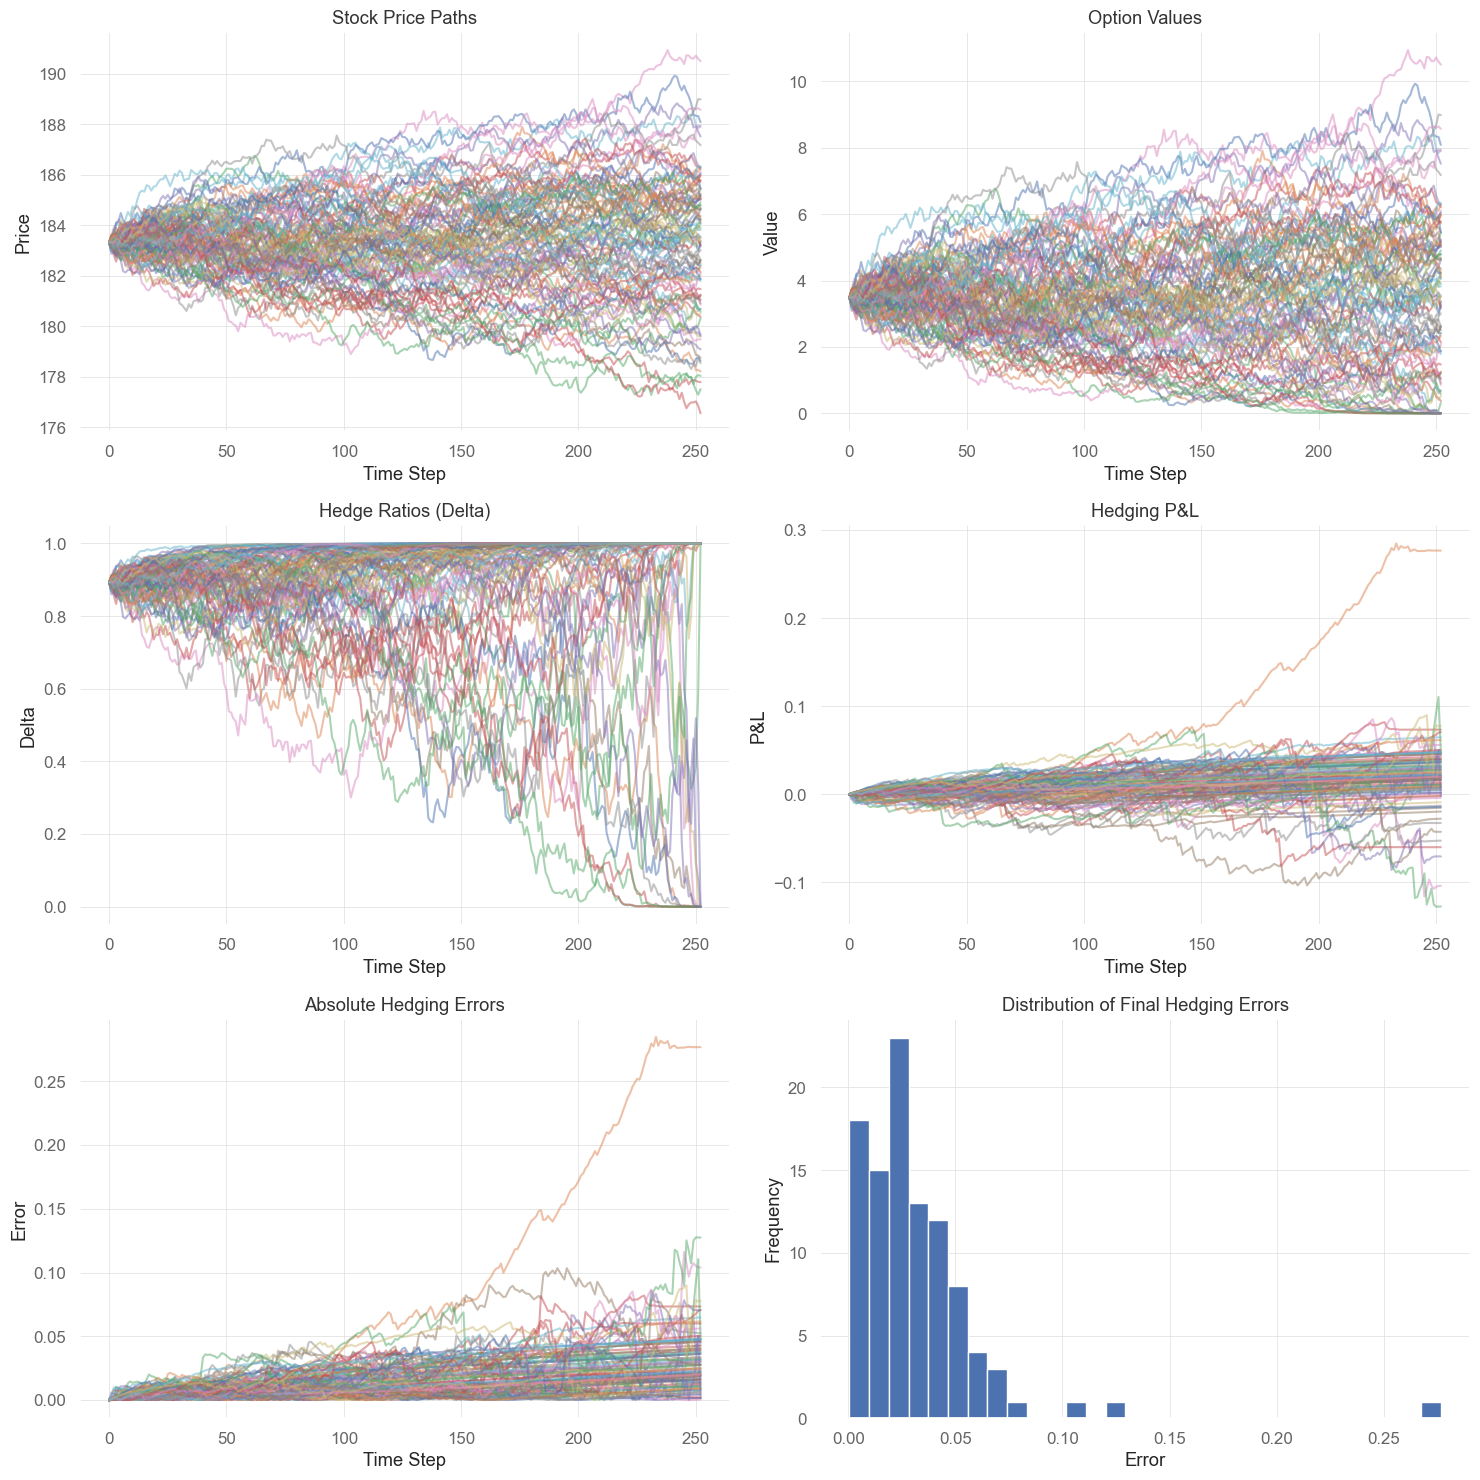

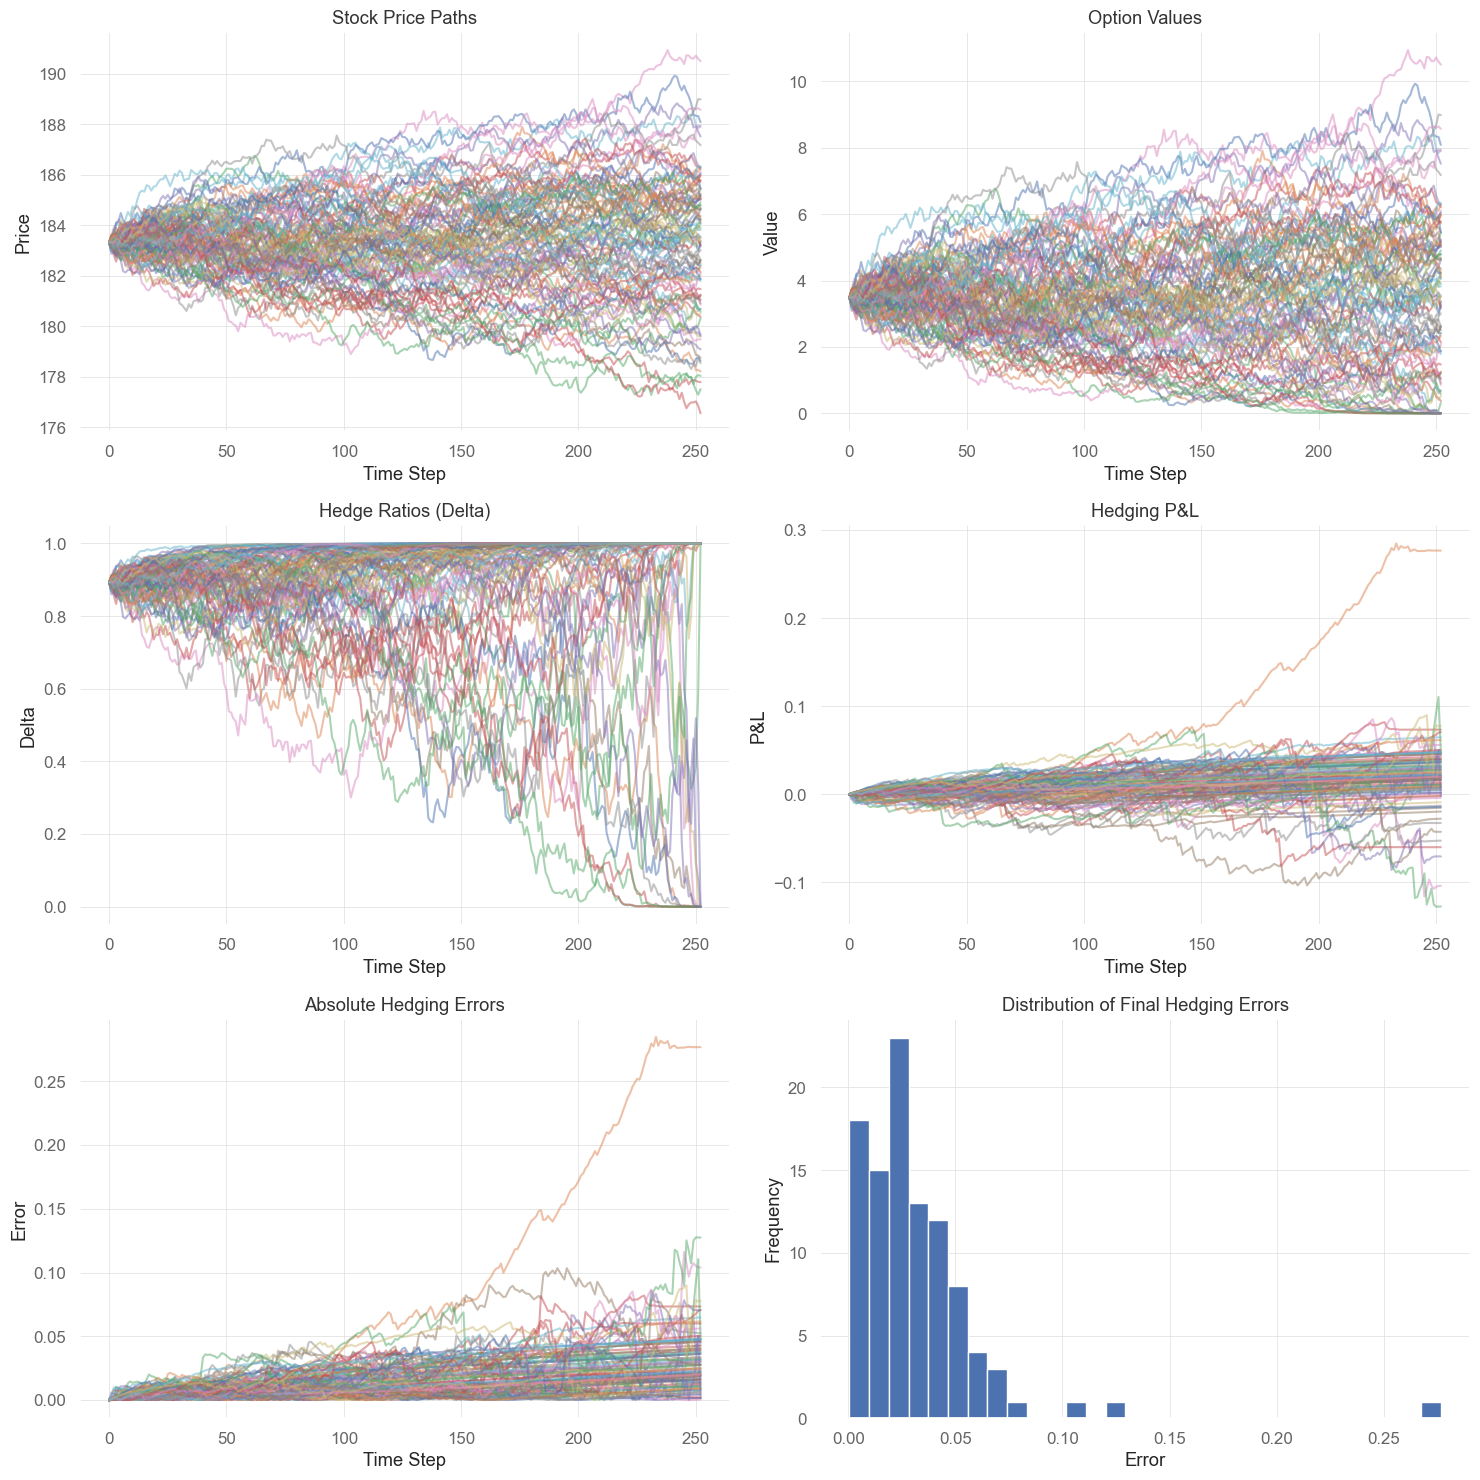

In [287]:
# Initialize with your parameters
hedger = DeltaHedging(
    S0=183.32,    # initial stock price
    K=180,        # strike price
    r=0.05,       # risk-free rate
    sigma=0.2848, # volatility
    T=1/365,      # time to maturity (1 day)
    mu=0.00474,   # expected return
    option_type='call'
)

# Run simulation
stock_prices, option_values, hedge_ratios, pnl, hedging_errors = hedger.simulate_hedging(
    n_steps=252,   # number of time steps in a year
    n_paths=100    # number of simulated paths
)

# Plot results
hedger.plot_results(stock_prices, option_values, hedge_ratios, pnl, hedging_errors)

# Run simulation
results = hedger.simulate_hedging(n_steps=252, n_paths=100)

# Generate comprehensive report
summary_stats, path_stats, fig = hedger.generate_report(*results)

# Access specific statistics
#print("\nDetailed path statistics:")
#print(path_stats.describe())

# Access specific summary statistics
#print("\nValue at Risk:")
#print(f"95% VaR: {abs(summary_stats['P&L']['VaR_95']):.4f}")